In [1]:
import numpy as np
import pandas as pd
import rasterio
from scipy import stats
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape

In [4]:
Tann = np.zeros(38)
for yl in range(38):
    tmean = np.load(f'./prism/mw_tmean/{1981+yl}_tmean.npz')['tmean']
    tmean = np.where(tmean>-100, tmean, np.nan)
    Tann[yl] = np.nanmean(tmean)

In [15]:
fgreen = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            fgreen[:, i, j] = df.fgreen
            
sgs = np.nanmean(fgreen, axis=(1, 2))

In [90]:
re_Tsgs = stats.linregress(Tann, sgs)
re_Tsgs

LinregressResult(slope=-4.346955372065389, intercept=131.9495823403233, rvalue=-0.5348786327112667, pvalue=0.000540753135751528, stderr=1.1444553343329729)

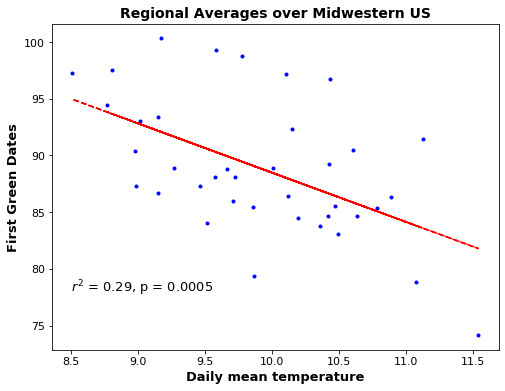

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, sgs, 'bo', ms=3)
plt.plot(Tann, re_Tsgs.slope * Tann + re_Tsgs.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('First Green Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 78, f'$r^{2}$ = {re_Tsgs.rvalue**2:.2f}, p = {re_Tsgs.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/fgreen_Tann.png')

In [3]:
lhfd = np.zeros((38, y, x)) * np.nan  # last hard freeze dates
for yl in range(38):
    tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
    tmin = np.where(tmin>-100, tmin, np.nan)
    for i in range(y):
        for j in range(x):
            if mask[i, j]:
                hfd = np.where(tmin[:, i, j]<-2.2)[0] # hard freeze dates
                if len(hfd):
                    lhfd[yl, i, j] = max(np.where(hfd < 180, hfd, 0))

np.save('last_hard_freeze_dates', lhfd)

In [3]:
lfd = np.zeros((38, y, x)) * np.nan  # last freeze dates
for yl in range(38):
    tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
    tmin = np.where(tmin>-100, tmin, np.nan)
    for i in range(y):
        for j in range(x):
            if mask[i, j]:
                lfdtemp = np.where(tmin[:, i, j]<0)[0] # freeze dates
                if len(lfd):
                    lfd[yl, i, j] = max(np.where(lfdtemp < 180, lfdtemp, 0))

np.save('last_freeze_dates', lfd)

In [103]:
lhfd_ann = np.nanmean(lhfd, axis=(1,2))
re_lhfd = stats.linregress(np.delete(Tann, 30), np.delete(lhfd_ann, 30))
re_lhfd

LinregressResult(slope=-4.319220118844468, intercept=145.17545783246027, rvalue=-0.592468731768644, pvalue=0.00011184201272114666, stderr=0.9927086478516157)

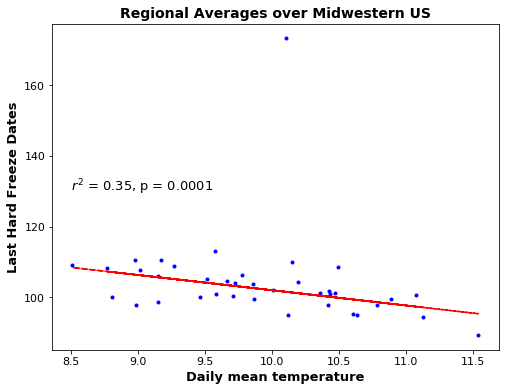

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, lhfd_ann, 'bo', ms=3)
plt.plot(Tann, re_lhfd.slope * Tann + re_lhfd.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('Last Hard Freeze Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 130, f'$r^{2}$ = {re_lhfd.rvalue**2:.2f}, p = {re_lhfd.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/LastHardFreezeDates_Tann.png')

In [7]:
slope = np.zeros((y, x)) * np.nan 
pvalue = np.zeros((y, x)) * np.nan 
X = np.linspace(1, 38, 38)
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            r = stats.linregress(X, lfd[:, i, j])
            slope[i, j] = r.slope
            pvalue[i, j] = r.pvalue
            
np.save('./var/LastFreeze_slope', slope)
np.save('./var/LastFreeze_pvalue', pvalue)

In [6]:
lhfd = np.load('last_freeze_dates.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(30, 170)
cmap = plt.get_cmap('jet_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, lhfd.mean(axis=0), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.title(f'Averaged Dates of Last Freeze (Tmin < 0 \u00b0C) Dates from 1981 to 2018', fontsize=12, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[40, 60, 80, 100, 120, 140, 160], extend='both')
plt.savefig(f'./plot/freeze_index/LastFreeze_mean.png')
plt.close()

In [52]:
slope = np.load('./var/LastHardFreeze_slope.npy')
pvalue = np.load('./var/LastHardFreeze_pvalue.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-1, 1)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.scatter(Lon, Lat, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())

for k in range(5):
    ax.plot(lonloc[k], latloc[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
    ax.text(lonloc[k]-.5, latloc[k]+.3, f'{k+1}', c='m', fontsize=15, transform=ccrs.PlateCarree())

plt.title(f'Trend of Last Hard Freeze (Tmin < 2.2 \u00b0C) Dates from 1981 to 2018', fontsize=13, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-1, 1.1, .2), extend='both')
# plt.savefig(f'./plot/freeze_index/LastFreeze_trend.png')
plt.close()

<ipython-input-52-c8a676ec0c88>:21: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [7]:
# lhfd = np.load('last_hard_freeze_dates.npy')
# slope = np.zeros((y, x)) * np.nan 
# pvalue = np.zeros((y, x)) * np.nan 
# X = np.linspace(1, 19, 19)
# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             r = stats.linregress(X, lhfd[:19, i, j])
#             slope[i, j] = r.slope
#             pvalue[i, j] = r.pvalue

# fig = plt.figure(figsize=(8, 6))
# extent = [-105, -75, 34, 49]
# ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
# ax.set_extent(extent)
# states = NaturalEarthFeature(category="cultural", scale="50m",
#                              facecolor="none",
#                              name="admin_1_states_provinces_shp")
# ax.add_feature(states, linewidth=.3, edgecolor="black")
# ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
# ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
# ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

# levels = MaxNLocator(nbins=100).tick_values(-3, 3)
# cmap = plt.get_cmap('bwr')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# pc = plt.pcolormesh(Lon, Lat, slope, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
# plt.scatter(Lon, Lat, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
# for k in range(5):
#     ax.plot(lonloc[k], latloc[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
#     ax.text(lonloc[k]-.5, latloc[k]+.3, f'{k+1}', c='m', fontsize=15, transform=ccrs.PlateCarree())

# plt.title(f'Trend of Last Hard Freeze (Tmin < 2.2 \u00b0C) Dates from 1981 to 1999', fontsize=13, fontweight='bold')

# fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
# cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
# cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-3, 3.1, .5), extend='both')  

<font size=4 color=blue>dates at individual location

In [4]:
latloc = [45.993005, 44.661906, 41.309247, 39.710815, 36.289078]
lonloc = [-87.647226, -84.546377, -87.292439, -81.960948, -97.326834]
yloc = np.zeros(5)
xloc = np.zeros(5)
for li in range(5):
    yloc[li] = np.argmin(abs(lat-latloc[li]))
    xloc[li] = np.argmin(abs(lon-lonloc[li]))
yloc = yloc.astype(int)
xloc = xloc.astype(int)
lhfd = np.load('last_freeze_dates.npy') 
X = np.linspace(1, 38, 38)
li = 4
plt.figure(figsize=(8, 6))
plt.plot(X, lhfd[:, yloc[li], xloc[li]], 'bo-', ms=3, lw=1)
plt.xticks(np.arange(1, 38, 3), [str(1981+i) for i in range(0, 38, 3)])
plt.title(str(li+1), fontsize='large', fontweight='bold')
plt.show()

In [15]:
# lhfd = np.load('last_hard_freeze_dates.npy')
# FSI = np.zeros((38, y, x)) * np.nan
# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             FSI[:, i, j] = lhfd[:, i, j] - df.fgreen
# np.save('./var/FSI', FSI)

lhfd = np.load('./var/last_hard_freeze_dates.npy')
FSI = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            FSI[:, i, j] = lhfd[:, i, j] - df.fgreen
np.save('./var/FSI_cherry', FSI)

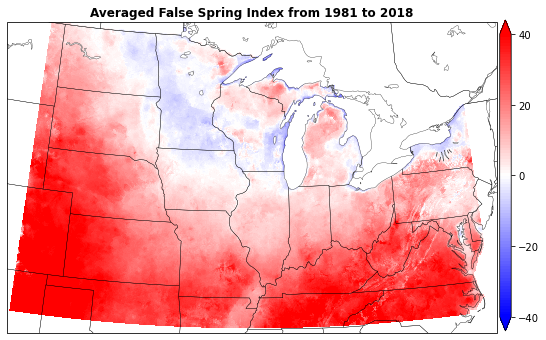

In [4]:
# FSI = np.load('./var/FSI.npy')
FSI = np.load('./var/FSI_cherry.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-40 ,40)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, FSI.mean(axis=0), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.title(f'Averaged False Spring Index from 1981 to 2018', fontsize=12, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-40, -20, 0, 20, 40],extend='both')
plt.savefig(f'./plot/freeze_index/Cherry_FSI_mean.png')

In [14]:
fsi_ann = np.nanmean(FSI, axis=(1,2))
re_fsi = stats.linregress(np.delete(Tann, 30), np.delete(fsi_ann, 30))
re_fsi

LinregressResult(slope=0.12185124392658679, intercept=12.538467990620104, rvalue=0.015212066283979576, pvalue=0.928795390214783, stderr=1.3538092608074237)

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, np.nanmean(FSI, axis=(1,2)), 'bo', ms=3)
plt.plot(Tann, re_fsi.slope * Tann + re_fsi.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('Last Hard Freeze Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 60, f'$r^{2}$ = {re_fsi.rvalue**2:.4f}, p = {re_fsi.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/FSI_Tann.png')

<font size=4 color=blue>Clip points in Michigan

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

In [24]:
usa = gpd.read_file('./states_21basic/states.shp')
mi_poly = usa[usa.STATE_ABBR == 'MI'].geometry

In [51]:
mi_mask = np.zeros((y, x))
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            p = Point(Lon[i, j], Lat[i, j])
            mi_mask[i, j] = np.array(mi_poly.contains(p))
np.save('./var/MI_mask', mi_mask)

<font size=4 color=blue>Tmean in March, April and May and Regional averages in Michigan

In [6]:
mi_mask = np.load('./var/MI_mask.npy')
Tann = np.zeros(38)
ttmean = np.zeros((92, y, x)) * np.nan
for yl in range(38):
    tmean = np.load(f'./prism/mw_tmean/{1981+yl}_tmean.npz')['tmean']
    tmean = np.where(tmean>-100, tmean, np.nan)
    for i in range(y):
        for j in range(x):
            if mi_mask[i, j]:
                ttmean[:, i, j] = tmean[59:151, i, j]
    Tann[yl] = np.nanmean(ttmean)

In [7]:
# fgreen = np.zeros((38, y, x)) * np.nan
# for i in range(y):
#     for j in range(x):
#         if mi_mask[i, j]:
#             df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
#             fgreen[:, i, j] = df.fgreen
            
# sgs = np.nanmean(fgreen, axis=(1, 2))

fgreen = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mi_mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            fgreen[:, i, j] = df.fgreen
            
sgs = np.nanmean(fgreen, axis=(1, 2))

In [8]:
# re_Tsgs = stats.linregress(np.delete(Tann, 30), np.delete(sgs, 30))
re_Tsgs = stats.linregress(Tann, sgs)
re_Tsgs

LinregressResult(slope=-5.0714233777794995, intercept=145.15312967868547, rvalue=-0.8648066168017726, pvalue=2.5626263506061476e-12, stderr=0.49074313502028916)

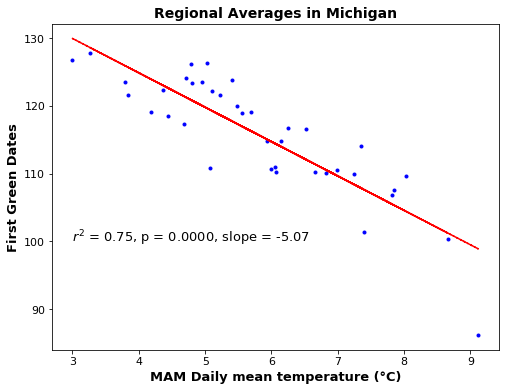

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, sgs, 'bo', ms=3)
plt.plot(Tann, re_Tsgs.slope * Tann + re_Tsgs.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('MAM Daily mean temperature (\u00b0C)', fontsize=13, fontweight='bold')
plt.ylabel('First Green Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages in Michigan', fontsize=14, fontweight='bold')
plt.text(3, 100, f'$r^{2}$ = {re_Tsgs.rvalue**2:.2f}, p = {re_Tsgs.pvalue:.4f}, slope = {re_Tsgs.slope:.2f}', fontsize=13)
plt.savefig('./plot/freeze_index/cherry_fgreen_Tann_MISpring.png')

In [12]:
lhfd = np.load('./var/last_hard_freeze_dates.npy')
lhfd = np.where(mi_mask, lhfd, np.nan)
lhfd_ann = np.nanmean(lhfd, axis=(1,2))
re_lhfd = stats.linregress(np.delete(Tann, 30), np.delete(lhfd_ann, 30))
re_lhfd

LinregressResult(slope=-2.399637825513381, intercept=132.33906648856498, rvalue=-0.5987062697848974, pvalue=9.059691901176732e-05, stderr=0.5426419903731474)

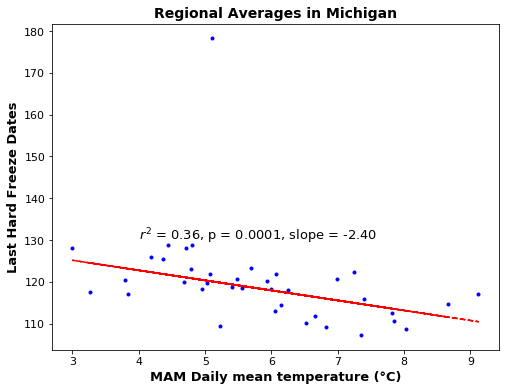

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, lhfd_ann, 'bo', ms=3)
plt.plot(Tann, re_lhfd.slope * Tann + re_lhfd.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('MAM Daily mean temperature (\u00b0C)', fontsize=13, fontweight='bold')
plt.ylabel('Last Hard Freeze Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages in Michigan', fontsize=14, fontweight='bold')
plt.text(4, 130, f'$r^{2}$ = {re_lhfd.rvalue**2:.2f}, p = {re_lhfd.pvalue:.4f}, slope = {re_lhfd.slope:.2f}', fontsize=13)
plt.savefig('./plot/freeze_index/LastHardFreezeDates_Tann_MISpring.png')

In [84]:
fsi = np.load('./var/FSI.npy')
fsi = np.array([np.where(mi_mask, fsi[yl, :, :], np.nan) for yl in range(38)])

In [94]:
fsi_ann = np.nanmean(fsi, axis=(1,2))
re_fsi = stats.linregress(np.delete(Tann, 30), np.delete(fsi_ann, 30))
re_fsi

LinregressResult(slope=2.425411044857143, intercept=-0.4265867510758561, rvalue=0.4185760622231596, pvalue=0.009928476627841718, stderr=0.8895076926965227)

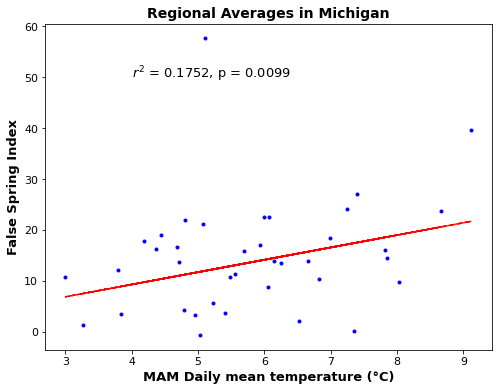

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, np.nanmean(fsi, axis=(1,2)), 'bo', ms=3)
plt.plot(Tann, re_fsi.slope * Tann + re_fsi.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('MAM Daily mean temperature (\u00b0C)', fontsize=13, fontweight='bold')
plt.ylabel('False Spring Index', fontsize=13, fontweight='bold')
plt.title('Regional Averages in Michigan', fontsize=14, fontweight='bold')
plt.text(4, 50, f'$r^{2}$ = {re_fsi.rvalue**2:.4f}, p = {re_fsi.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/FSI_Tann_MISpring.png')

In [5]:
# gddac = np.zeros((38, y, x)) * np.nan
# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True, 
#                                    names=('YR','cd','TMAX','TMIN','gdd','CDHTOT','STAGE','DAM','YLD','INJDAYS'))
#             gddac[:, i, j] = np.array([df.gdd[365*i:59+365*i].sum() for i in range(38)])
# np.save('./var/GDD_JF_Accu', gddac)

In [3]:
fsi = np.load('./var/FSI_cherry.npy')
slope = np.zeros((y, x)) * np.nan
pvalue = np.zeros((y, x)) * np.nan
rvalue = np.zeros((y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            r = stats.linregress(fsi[:, i, j], df.pdays)
            slope[i, j] = r.slope
            pvalue[i, j] = r.pvalue
            rvalue[i, j] = r.rvalue
np.save('./var/pdays_fsi_slope', slope)
np.save('./var/pdays_fsi_pvalue', pvalue)
np.save('./var/pdays_fsi_rvalue', rvalue)

In [3]:
fsi = np.load('./var/FSI_cherry.npy')
slope = np.zeros((y, x)) * np.nan
pvalue = np.zeros((y, x)) * np.nan
rvalue = np.zeros((y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','pdays','yield'))
            r = stats.linregress(fsi[:, i, j], df['yield'])
            slope[i, j] = r.slope
            pvalue[i, j] = r.pvalue
            rvalue[i, j] = r.rvalue
np.save('./var/yield_fsi_slope', slope)
np.save('./var/yield_fsi_pvalue', pvalue)
np.save('./var/yield_fsi_rvalue', rvalue)

<ipython-input-21-021c1a9ebbbc>:18: RuntimeWarning: invalid value encountered in less
  pc = plt.pcolormesh(Lon, Lat, np.where(pvalue<.05, slope*100, np.nan), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())


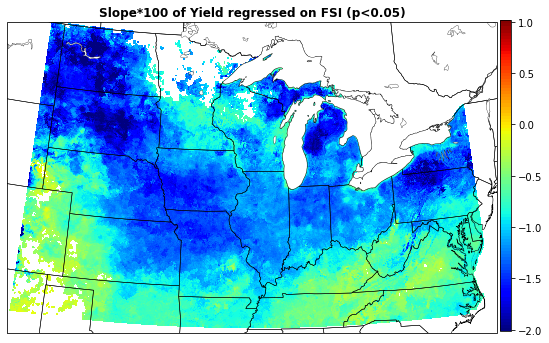

In [21]:
slope = np.load('./var/yield_fsi_slope.npy')
pvalue = np.load('./var/yield_fsi_pvalue.npy')
rvalue = np.load('./var/yield_fsi_rvalue.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-2,1)
cmap = plt.get_cmap('jet')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, np.where(pvalue<.05, slope*100, np.nan), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.title('Slope*100 of Yield regressed on FSI (p<0.05)', fontsize=12, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-2, 1.5, .5))
# plt.savefig(f'./plot/freeze_index/Cherry_FSI_mean.png')